# GNEE Event Embedding
This notebook establishes a training pipeline for our Event Embedding model.

## Installing our libraries and required scripts

In [ ]:
!git clone https://github.com/joaopedromattos/pyGAT
!pip install --quiet spektral

Cloning into 'pyGAT'...
remote: Enumerating objects: 213, done.
remote: Total 213 (delta 0), reused 0 (delta 0), pack-reused 213
Receiving objects: 100% (213/213), 324.96 KiB | 1.08 MiB/s, done.
Resolving deltas: 100% (117/117), done.
     |████████████████████████████████| 122kB 8.6MB/s 


In [ ]:
!pip install git+https://github.com/rmarcacini/sentence-transformers
!pip install gdown
!gdown https://drive.google.com/uc?id=1NV5t1YhyyOzMF5zAovfbSLdZZLvqrfZ_
!unzip distiluse-base-multilingual-cased.zip -d language_model
from sentence_transformers import SentenceTransformer, LoggingHandler
language_model = SentenceTransformer('distiluse-base-multilingual-cased')

  Cloning https://github.com/rmarcacini/sentence-transformers to /tmp/pip-req-build-9dcev7se
  Running command git clone -q https://github.com/rmarcacini/sentence-transformers /tmp/pip-req-build-9dcev7se
     |████████████████████████████████| 890kB 8.1MB/s 
     |████████████████████████████████| 3.0MB 22.9MB/s 
     |████████████████████████████████| 1.2MB 38.6MB/s 
     |████████████████████████████████| 890kB 43.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.6-cp36-none-any.whl size=101875 sha256=826dccc6a47dc4f8a9dc63da09805fe0122f8b51281b3a60d495121bc400fa67
  Stored in directory: /tmp/pip-ephem-wheel-cache-smsekkcx/wheels/88/3c/66/55ee9fb698480d5a5116a8257c15dc363323e4922fb8ad361b
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=67216cfa63a8d891011b2bf8f4a698b6f7a8b138c1d9d763f1436ace88b550f2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f

100%|██████████| 504M/504M [00:31<00:00, 16.1MB/s]


In [ ]:
import os

os.chdir('./pyGAT')

In [ ]:
import networkx as nx
from tqdm import tqdm
import pandas as pd
from google.colab import auth
from google.cloud import bigquery
from google.cloud import bigquery_storage
import numpy as np
import logging
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, LabelEncoder
from event_graph_utils import mount_graph, regularization, process_event_dataset_from_networkx
from train import GAT_wrapper

# auth.authenticate_user()
# print('Authenticated')

## 5W1H Graph Events

In [ ]:
!gdown --id 1RF_bIo5ndxPhu9SJw-T8HBcuHyaGQGL0

Downloading...
From: https://drive.google.com/uc?id=1RF_bIo5ndxPhu9SJw-T8HBcuHyaGQGL0
To: /content/pyGAT/datasets.tar.gz
22.7MB [00:00, 106MB/s] 


In [ ]:
!tar -xzvf datasets.tar.gz

datasets_runs/
datasets_runs/run_1_google_news_5w1h_graph_hin.nx
datasets_runs/run_6_40er_5w1h_graph_hin.nx
datasets_runs/run_4_bbc_5w1h_graph_hin.nx
datasets_runs/run_8_gold_standard_5w1h_graph_hin.nx
datasets_runs/run_5_bbc_5w1h_graph_hin.nx
datasets_runs/run_9_google_news_5w1h_graph_hin.nx
datasets_runs/run_5_gold_standard_5w1h_graph_hin.nx
datasets_runs/run_2_bbc_5w1h_graph_hin.nx
datasets_runs/run_9_news_cluster_5w1h_graph_hin.nx
datasets_runs/run_7_40er_5w1h_graph_hin.nx
datasets_runs/run_9_gold_standard_5w1h_graph_hin.nx
datasets_runs/run_8_google_news_5w1h_graph_hin.nx
datasets_runs/run_10_bbc_5w1h_graph_hin.nx
datasets_runs/run_8_news_cluster_5w1h_graph_hin.nx
datasets_runs/run_2_news_cluster_5w1h_graph_hin.nx
datasets_runs/run_8_40er_5w1h_graph_hin.nx
datasets_runs/run_6_bbc_5w1h_graph_hin.nx
datasets_runs/run_4_google_news_5w1h_graph_hin.nx
datasets_runs/run_2_google_news_5w1h_graph_hin.nx
datasets_runs/run_7_gold_standard_5w1h_graph_hin.nx
datasets_runs/run_4_gold_standard_

# Regularization

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import random


def regularization(G, dim, embedding_feature: str = 'embedding', iterations=15, mi=0.85):

    nodes = []

    # inicializando vetor f para todos os nodes
    for node in G.nodes():
        G.nodes[node]['f'] = np.array([0.0]*dim)
        if embedding_feature in G.nodes[node]:
            G.nodes[node]['f'] = G.nodes[node][embedding_feature]*1.0
        nodes.append(node)

    pbar = tqdm(range(0, iterations))

    for iteration in pbar:
        random.shuffle(nodes)
        energy = 0.0

        # percorrendo cada node
        for node in nodes:
            f_new = np.array([0.0]*dim)
            f_old = np.array(G.nodes[node]['f'])*1.0
            sum_w = 0.0

            # percorrendo vizinhos do onde
            for neighbor in G.neighbors(node):
                w = 1.0
                if 'weight' in G[node][neighbor]:
                    w = G[node][neighbor]['weight']

                w /= np.sqrt(G.degree[neighbor])

                f_new += w*G.nodes[neighbor]['f']

                sum_w += w

            f_new /= sum_w

            G.nodes[node]['f'] = f_new*1.0

            if embedding_feature in G.nodes[node]:
                G.nodes[node]['f'] = G.nodes[node][embedding_feature] * \
                    mi + G.nodes[node]['f']*(1.0-mi)

            energy += np.linalg.norm(f_new-f_old)

        iteration += 1
        message = 'Iteration '+str(iteration)+' | Energy = '+str(energy)
        pbar.set_description(message)

    return G

In [ ]:
import numpy as np
import networkx as nx
import random
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import logging
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split


def process_event_dataset_from_networkx(G, features_attr="f"):
    """
    Builds an event graph dataset used in GAT model
    Parameters:
        G -> Graph representation of the event network (Networkx graph)
        df_labels -> user labeled data
        features_att -> Feature attribute of each node (str)
        random_state -> A random seed to train_test_split
    Returns:
        adj -> Sparse and symmetric adjacency matrix of our graph.
        features -> A NumPy matrix with our graph features.
        idx_train -> A NumPy array with the indexes of the training nodes.
        idx_val -> A NumPy array with the indexes of the validation nodes.
        idx_test -> A NumPy array with the indexes of the test nodes.
    """

    num_nodes = len(G.nodes)


    

    # validation_split_percentage = val_split / (1 - train_split)

    # df_val, df_test = train_test_split(
    #     df_test_and_val, train_size=validation_split_percentage, random_state=random_state)

    # Organizing our feature matrix...
    # feature_matrix = np.array([ G.nodes[i]['embedding'] if 'embedding' in G.nodes[i].keys() else G.nodes[i][features_attr] for i in G.nodes()])
    #features = np.array([G.nodes[i][features_attr] for i in G.nodes()])
    L_features = []
    L_train = []
    L_test = []
    L_labels = []
    label_codes = {}
    for node in G.nodes():
      L_features.append( (G.nodes[node]['id'], G.nodes[node]['f']) )
      if 'train' in G.nodes[node]: L_train.append(G.nodes[node]['id'])
      if 'test' in G.nodes[node]: L_test.append(G.nodes[node]['id'])
      if 'label' in G.nodes[node]:
        if G.nodes[node]['label'] not in label_codes: label_codes[G.nodes[node]['label']] = len(label_codes) 
        L_labels.append( [G.nodes[node]['id'],G.nodes[node]['label'],label_codes[G.nodes[node]['label']]] )
    df_features = pd.DataFrame(L_features)
    df_features.columns = ['node_id','embedding']
    features = np.array(df_features.sort_values(by=['node_id'])['embedding'].to_list())

    idx_train = L_train
    idx_test = L_test
    labels = [-1]*num_nodes
    df_labels = pd.DataFrame(L_labels)
    df_labels.columns = ['event_id','label','label_code']
    for index,row in df_labels.iterrows():
      labels[row['event_id']] = row['label_code']

    adj = nx.adjacency_matrix(G)

    return adj, features, labels, idx_train, idx_test, df_labels

## Training

In [ ]:
from __future__ import division
from __future__ import print_function

import os
import glob
import time
import random
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import scipy.sparse as sp


from models import GAT, SpGAT


def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)


def normalize_adj(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv_sqrt = np.power(rowsum, -0.5).flatten()
    r_inv_sqrt[np.isinf(r_inv_sqrt)] = 0.
    r_mat_inv_sqrt = sp.diags(r_inv_sqrt)
    return mx.dot(r_mat_inv_sqrt).transpose().dot(r_mat_inv_sqrt)

class Namespace(object):
    def __init__(self, adict):
        self.__dict__.update(adict)

class GAT_wrapper():
    def __init__(self, args={"alpha": 0.2, "cuda": True, "dropout": 0.6, "epochs": 10, "fastmode": False, "hidden": 8, "lr": 0.005, "nb_heads": 8, "no_cuda": False, "patience": 100, "seed": 72, "sparse": False, "weight_decay": 0.0005}):

        if (type(args) == dict):
            args = Namespace(args)

        self.args = args

        self.model = None

        self.loss_test = 0.0
        self.acc_test = 0.0

        self.adj = None
        self.features = None
        self.labels = None
        self.idx_train = None
        self.idx_val = None
        self.idx_test = None

    def compute_test(self):
        self.model.eval()
        output = self.model(self.features, self.adj)
        loss_test = F.nll_loss(
            output[self.idx_test], self.labels[self.idx_test])
        acc_test = accuracy(output[self.idx_test], self.labels[self.idx_test])
        print("Test set results:",
              "loss= {:.4f}".format(loss_test.item()),
              "accuracy= {:.4f}".format(acc_test.item()))

        self.loss_test = loss_test
        self.acc_test = acc_test

        return loss_test, acc_test, output[self.idx_test].max(1)[1]

    def train_pipeline(self, adj, features, labels, idx_train, idx_val, idx_test, *args):

        adj = normalize_adj(adj + sp.eye(adj.shape[0]))

        if (sp.issparse(adj)):
            adj = adj.todense()

        if (sp.issparse(features)):
            features = features.todense()

        # With networkx, we no longer need to convert from one-hot encoding...
        #labels = np.where(labels)[1]

        adj = torch.FloatTensor(adj)
        features = torch.FloatTensor(features)
        labels = torch.LongTensor(labels)
        idx_train = torch.LongTensor(idx_train)
        idx_val = torch.LongTensor(idx_val)
        idx_test = torch.LongTensor(idx_test)

        random.seed(self.args.seed)
        np.random.seed(self.args.seed)
        torch.manual_seed(self.args.seed)
        if self.args.cuda:
            torch.cuda.manual_seed(self.args.seed)

        # Load data
        # adj, features, labels, idx_train, idx_val, idx_test = new_load_data(
        #     *args, custom_function=custom_function, function=function)

        # Model and optimizer
        if self.args.sparse:
            model = SpGAT(nfeat=features.shape[1],
                          nhid=self.args.hidden,
                          nclass=int(labels.max()) + 1,
                          dropout=self.args.dropout,
                          nheads=self.args.nb_heads,
                          alpha=self.args.alpha)
        else:
            model = GAT(nfeat=features.shape[1],
                        nhid=self.args.hidden,
                        nclass=int(labels.max()) + 1,
                        dropout=self.args.dropout,
                        nheads=self.args.nb_heads,
                        alpha=self.args.alpha)
        optimizer = optim.Adam(model.parameters(),
                               lr=self.args.lr,
                               weight_decay=self.args.weight_decay)

        if self.args.cuda:
            model.cuda()
            features = features.cuda()
            adj = adj.cuda()
            labels = labels.cuda()
            idx_train = idx_train.cuda()
            idx_val = idx_val.cuda()
            idx_test = idx_test.cuda()

        features, adj, labels = Variable(
            features), Variable(adj), Variable(labels)

        # TODO: Test if these lines could be written below line 41.
        self.adj = adj
        self.features = features
        self.labels = labels
        self.idx_train = idx_train
        self.idx_val = idx_val
        self.idx_test = idx_test

        def train(epoch):
            t = time.time()
            model.train()
            optimizer.zero_grad()
            output = model(features, adj)
            loss_train = F.nll_loss(output[idx_train], labels[idx_train])
            acc_train = accuracy(output[idx_train], labels[idx_train])
            loss_train.backward()
            optimizer.step()

            if not self.args.fastmode:
                # Evaluate validation set performance separately,
                # deactivates dropout during validation run.
                model.eval()
                output = model(features, adj)

            loss_val = F.nll_loss(output[idx_val], labels[idx_val])
            acc_val = accuracy(output[idx_val], labels[idx_val])
            print('Epoch: {:04d}'.format(epoch+1),
                  'loss_train: {:.4f}'.format(loss_train.data.item()),
                  'acc_train: {:.4f}'.format(acc_train.data.item()),
                  'loss_val: {:.4f}'.format(loss_val.data.item()),
                  'acc_val: {:.4f}'.format(acc_val.data.item()),
                  'time: {:.4f}s'.format(time.time() - t))

            return loss_val.data.item()

        # Train model
        t_total = time.time()
        loss_values = []
        bad_counter = 0
        best = self.args.epochs + 1
        best_epoch = 0
        for epoch in range(self.args.epochs):
            loss_values.append(train(epoch))

            torch.save(model.state_dict(), '{}.pkl'.format(epoch))
            if loss_values[-1] < best:
                best = loss_values[-1]
                best_epoch = epoch
                bad_counter = 0
            else:
                bad_counter += 1

            if bad_counter == self.args.patience:
                break

            files = glob.glob('*.pkl')
            for file in files:
                epoch_nb = int(file.split('.')[0])
                if epoch_nb < best_epoch:
                    os.remove(file)

        files = glob.glob('*.pkl')
        for file in files:
            epoch_nb = int(file.split('.')[0])
            if epoch_nb > best_epoch:
                os.remove(file)

        print("Optimization Finished!")
        print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

        # Restore best model
        print('Loading {}th epoch'.format(best_epoch))
        model.load_state_dict(torch.load('{}.pkl'.format(best_epoch)))

        self.model = model

        return model



In [ ]:
from os import listdir
from os.path import isfile, join
path_datasets = 'datasets_runs/'
network_files = [f for f in listdir(path_datasets) if isfile(join(path_datasets, f))]
print(network_files)

['run_3_40er_5w1h_graph_hin.nx', 'run_10_google_news_5w1h_graph_hin.nx', 'run_10_news_cluster_5w1h_graph_hin.nx', 'run_7_bbc_5w1h_graph_hin.nx', 'run_10_gold_standard_5w1h_graph_hin.nx', 'run_8_40er_5w1h_graph_hin.nx', 'run_2_bbc_5w1h_graph_hin.nx', 'run_5_bbc_5w1h_graph_hin.nx', 'run_8_gold_standard_5w1h_graph_hin.nx', 'run_5_40er_5w1h_graph_hin.nx', 'run_1_bbc_5w1h_graph_hin.nx', 'run_7_gold_standard_5w1h_graph_hin.nx', 'run_1_gold_standard_5w1h_graph_hin.nx', 'run_2_gold_standard_5w1h_graph_hin.nx', 'run_8_bbc_5w1h_graph_hin.nx', 'run_1_google_news_5w1h_graph_hin.nx', 'run_6_bbc_5w1h_graph_hin.nx', 'run_5_google_news_5w1h_graph_hin.nx', 'run_1_news_cluster_5w1h_graph_hin.nx', 'run_2_news_cluster_5w1h_graph_hin.nx', 'run_6_news_cluster_5w1h_graph_hin.nx', 'run_1_40er_5w1h_graph_hin.nx', 'run_6_gold_standard_5w1h_graph_hin.nx', 'run_6_google_news_5w1h_graph_hin.nx', 'run_4_google_news_5w1h_graph_hin.nx', 'run_5_gold_standard_5w1h_graph_hin.nx', 'run_4_bbc_5w1h_graph_hin.nx', 'run_4_40

In [ ]:
network_files = ['run_1_gold_standard_5w1h_graph_hin.nx']

In [ ]:
!pwd

/content/pyGAT


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm

experimental_results = []

for network_file in tqdm(network_files):

  if 'news_cluster_5w1h_graph_hin.nx' in network_file: continue # usando toda a RAM as vezes???
  print('Networkfile',network_file)
  

  G = nx.read_gpickle(path_datasets+network_file)

  regularization(G, 512, embedding_feature='features')
  adj, features, labels, idx_train, idx_test, df_labels = process_event_dataset_from_networkx(G)
  print(adj.shape,features.shape,len(idx_train),len(idx_test))
  gat = GAT_wrapper({"alpha": 0.2, "cuda": False, "dropout": 0.5, "epochs": 20, "fastmode": False, "hidden": 8, "lr": 0.005, "nb_heads": 8, "no_cuda": False, "patience": 100, "seed": 72, "sparse": False, "weight_decay": 0.0005})
  gat.train_pipeline(adj, features, labels, idx_train, idx_train, idx_test)
  loss, acc, output = gat.compute_test()
  y_pred = output.numpy()
  y_true = []
  for event_id in idx_test:
    for node in G.nodes():
      if ':event' in node:
        if G.nodes[node]['id'] == event_id:
          y_true.append(df_labels[df_labels.event_id==event_id].label_code.values[0])

  f1_macro = f1_score(y_true, y_pred, average='macro')
  acc = accuracy_score(y_true, y_pred)

  print('--->' ,network_file,'f1_macro',f1_macro,'acc',acc)
  experimental_results.append((network_file,'f1_macro',f1_macro,'acc',acc,y_true,y_pred))
  # del gat
  # del adj
  # del features
  # del G

Networkfile run_1_gold_standard_5w1h_graph_hin.nx



(579, 579) (579, 512) 20 76
Epoch: 0001 loss_train: 2.6240 acc_train: 0.0500 loss_val: 2.4008 acc_val: 0.5500 time: 0.8312s
Epoch: 0002 loss_train: 2.3812 acc_train: 0.3000 loss_val: 2.2099 acc_val: 0.8000 time: 0.8060s
Epoch: 0003 loss_train: 2.2570 acc_train: 0.7000 loss_val: 2.0337 acc_val: 0.8500 time: 0.8672s
Epoch: 0004 loss_train: 2.1015 acc_train: 0.7000 loss_val: 1.8682 acc_val: 0.8500 time: 0.9949s
Epoch: 0005 loss_train: 1.8695 acc_train: 0.8500 loss_val: 1.7097 acc_val: 0.8500 time: 0.9040s
Epoch: 0006 loss_train: 1.8435 acc_train: 0.8500 loss_val: 1.5637 acc_val: 0.8500 time: 0.9255s
Epoch: 0007 loss_train: 1.4539 acc_train: 0.8500 loss_val: 1.4259 acc_val: 0.9500 time: 0.9863s
Epoch: 0008 loss_train: 1.4526 acc_train: 0.9000 loss_val: 1.2976 acc_val: 0.9500 time: 1.1958s
Epoch: 0009 loss_train: 1.3843 acc_train: 0.9500 loss_val: 1.1775 acc_val: 0.9500 time: 0.8280s
Epoch: 0010 loss_train: 1.3797 acc_train: 0.9500 loss_val: 1.0675 acc_val: 0.9500 time: 0.9502s
Epoch: 0011

In [ ]:
df_results = pd.DataFrame(experimental_results)
df_results

,0,1,2,3,4,5,6
0,run_5_gold_standard_5w1h_graph_hin.nx,f1_macro,0.70537,acc,0.815789,"[0, 1, 2, 3, 4, 0, 1, 6, 0, 1, 5, 7, 0, 4, 6, ...","[0, 1, 2, 3, 8, 0, 1, 6, 0, 1, 5, 1, 0, 5, 6, ..."


In [ ]:
df_results.to_excel('gat_results_r1.xls')

# Embedding Visualization (t-SNE)

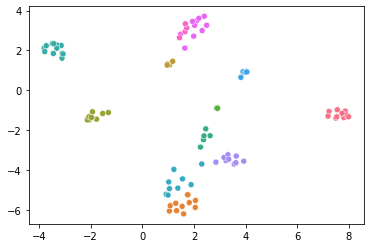

In [ ]:
embedding = gat.model.get_attention_heads_outputs(gat.features,gat.adj).detach().numpy()

counter = 0
X = []
Y = []
for node in G.nodes():
  if ':event' in node:
    X.append(embedding[counter])
    Y.append(G.nodes[node]['label'])

  counter += 1

X = np.array(X)



import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

df = pd.DataFrame(X_embedded)
df['label'] = Y
df = df.dropna()

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

g = sns.scatterplot(x=0, y=1, data=df, hue="label", legend=False)
g.set(xlabel=None)
g.set(ylabel=None)

plt.savefig('../gnee.pdf')

(96, 2)

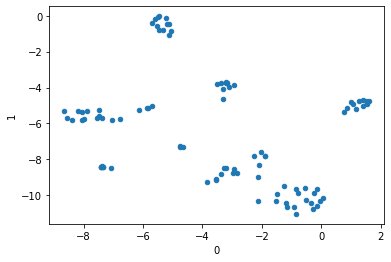

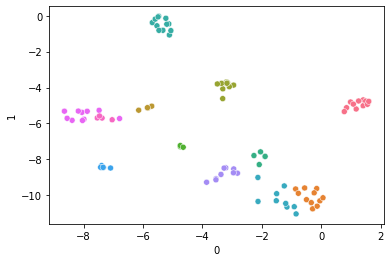